# Sklearn intro 1.0 - SVM
by Michele Svanera


In [1]:
# All imports
import numpy as np
import matplotlib.pyplot as plt 
import sklearn
import time
from sklearn.metrics import classification_report

In [2]:
# Load database
from sklearn.datasets import load_digits
digits = load_digits()
all_data = digits.data
GT = digits.target

Shape: (1797, 64)
GT values: [0 1 2 3 4 5 6 7 8 9]


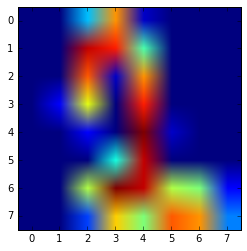

sample range is: MAX=16, min=0
GT of the sample 2


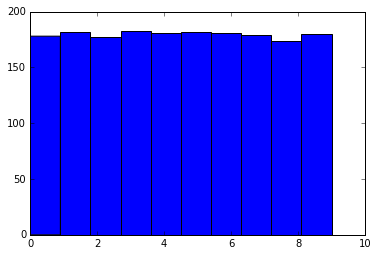

How many samples per class: [ 178.  182.  177.  183.  181.  182.  181.  179.  174.  180.]


In [3]:
# What we have?
n_samples, m_features = all_data.shape
print 'Shape: ' + str(all_data.shape)
print 'GT values: ' + str(np.unique(GT))

one_sample = np.reshape(all_data[12,:],(int(np.sqrt(m_features)),int(np.sqrt(m_features))))
plt.imshow(one_sample)
plt.show()
print 'sample range is: MAX=%d, min=%d' % (np.max(one_sample),np.min(one_sample))
print 'GT of the sample %d' % GT[12]
plt.figure()
how_many_samples_per_class = plt.hist(GT)
plt.show()
print 'How many samples per class: ' + str(how_many_samples_per_class[0])

In [4]:
# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        all_data, GT, test_size=0.30, random_state=42)

X_test, X_valid, y_test, y_valid = train_test_split(
        X_test, y_test, test_size=0.50, random_state=42)

y_train = y_train.reshape(-1)
y_valid = y_valid.reshape(-1)
y_test = y_test.reshape(-1)

print 'Shape (train): ' + str(X_train.shape)
print 'Shape (valid): ' + str(X_valid.shape)
print 'Shape (test): ' + str(X_test.shape)

Shape (train): (1257, 64)
Shape (valid): (270, 64)
Shape (test): (270, 64)


In [5]:
# Fast SVM trial
from sklearn.svm import LinearSVC
clf = LinearSVC()

t = time.time()
print 'Training linear SVM...'
clf.fit(X_train,y_train)
print 'Done in (sec): %.3f' % (time.time() - t)

y_valid_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_valid_pred, target_names=['Class_' + str(i) for i in np.unique(GT)]))
print 'Total accuracy (%%): %.3f' % (clf.score(X_valid,y_valid)*100)

Training linear SVM...
Done in (sec): 0.119
             precision    recall  f1-score   support

    Class_0       1.00      1.00      1.00        31
    Class_1       0.95      0.83      0.89        24
    Class_2       0.93      0.93      0.93        27
    Class_3       0.97      0.94      0.95        33
    Class_4       1.00      1.00      1.00        29
    Class_5       0.92      0.85      0.88        27
    Class_6       1.00      0.96      0.98        23
    Class_7       0.96      0.96      0.96        27
    Class_8       0.71      0.96      0.81        25
    Class_9       0.91      0.83      0.87        24

avg / total       0.94      0.93      0.93       270

Total accuracy (%): 92.963


## Let start scaling data
Importance of Feature Scaling [here](http://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html)

In [6]:
# Let's scale the data first
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

print 'Shape (train): ' + str(X_train.shape)
print 'Shape (valid): ' + str(X_valid.shape)
print 'Shape (test): ' + str(X_test.shape)

Shape (train): (1257, 64)
Shape (valid): (270, 64)
Shape (test): (270, 64)


In [7]:
# SVM trial after scaling
clf = LinearSVC()

t = time.time()
print 'Training linear SVM...'
clf.fit(X_train,y_train)
print 'Done in (sec): %.3f' % (time.time() - t)

y_valid_pred = clf.predict(X_valid)
print(classification_report(y_valid, y_valid_pred, target_names=['Class_' + str(i) for i in np.unique(GT)]))
print 'Total accuracy (%%): %.3f' % (clf.score(X_valid,y_valid)*100)

Training linear SVM...
Done in (sec): 0.171
             precision    recall  f1-score   support

    Class_0       1.00      1.00      1.00        31
    Class_1       0.96      1.00      0.98        24
    Class_2       0.96      1.00      0.98        27
    Class_3       0.97      0.94      0.95        33
    Class_4       0.97      0.97      0.97        29
    Class_5       0.92      0.89      0.91        27
    Class_6       1.00      0.96      0.98        23
    Class_7       0.96      1.00      0.98        27
    Class_8       0.96      0.96      0.96        25
    Class_9       0.92      0.92      0.92        24

avg / total       0.96      0.96      0.96       270

Total accuracy (%): 96.296


## skopt
Scikit-Optimize ([link](https://scikit-optimize.github.io/)), or skopt, is a simple and efficient library to minimize (very) expensive and noisy black-box functions. It implements several methods for sequential model-based optimization. skopt is reusable in many contexts and accessible.

In [8]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split

opt = BayesSearchCV(SVC(), { 'C': Real(1e-6, 1e+6, prior='log-uniform'), 
                            'gamma': Real(1e-6, 1e+1, prior='log-uniform'), 
                            'degree': Integer(1,8), 'kernel': Categorical(['linear', 'poly', 'rbf']), }, 
                    n_iter=250, n_jobs=-1, scoring='accuracy') #'accuracy')
t = time.time()
opt.fit(X_train, y_train)
print 'Optimisation of SVM done in (sec): %.3f' % (time.time() - t)

/usr/local/lib/python2.7/dist-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Optimisation of SVM done in (sec): 956.687


In [9]:
print opt

BayesSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_iter=250, n_jobs=-1,
       optimizer_kwargs={}, pre_dispatch='2*n_jobs', random_state=None,
       refit=True, return_train_score=True, scoring='accuracy',
       search_spaces=None, verbose=0)


In [10]:
opt.best_estimator_

SVC(C=74.771406808403128, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=8, gamma=0.0081704278109310802,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [11]:
opt.search_spaces_

{0: {'C': Real(low=1e-06, high=1000000.0, prior=log-uniform, transform=identity),
  'degree': Integer(low=1, high=8),
  'gamma': Real(low=1e-06, high=10.0, prior=log-uniform, transform=identity),
  'kernel': Categorical(categories=('linear', 'poly', 'rbf'), prior=None)}}

In [12]:
print 'Score on train-set (%%): %.3f' % (opt.score(X_train, y_train)*100)
print 'Score on valid-set (%%): %.3f' % (opt.score(X_valid, y_valid)*100)
print 'Score on test -set (%%): %.3f' % (opt.score(X_test, y_test)*100)

Score on train-set (%): 100.000
Score on valid-set (%): 98.519
Score on test -set (%): 98.148


## Save and load the model

In [13]:
from sklearn.externals import joblib

joblib.dump(opt, './data/my_model.pkl')

['./data/my_model.pkl']

In [14]:
my_loaded_clf = joblib.load('./data/my_model.pkl')
print 'Score on test -set (%%): %.3f' % (my_loaded_clf.score(X_test, y_test)*100)
y_test_pred = my_loaded_clf.predict(X_test)
print(classification_report(y_test, y_test_pred, target_names=['Class_' + str(i) for i in np.unique(GT)]))

Score on test -set (%): 98.148
             precision    recall  f1-score   support

    Class_0       1.00      1.00      1.00        22
    Class_1       1.00      1.00      1.00        26
    Class_2       0.95      1.00      0.98        20
    Class_3       1.00      0.95      0.98        21
    Class_4       1.00      1.00      1.00        31
    Class_5       1.00      0.97      0.99        39
    Class_6       0.97      1.00      0.98        30
    Class_7       0.96      0.96      0.96        28
    Class_8       1.00      1.00      1.00        18
    Class_9       0.94      0.94      0.94        35

avg / total       0.98      0.98      0.98       270



Someone asked for a comparison between classifiers? Take a look [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)!

Do you still want to use SVM? Take a look at [this](http://scikit-learn.org/stable/auto_examples/applications/svm_gui.html).

### The end!